In [ ]:
import numpy as np
from pcgym import make_env
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.gridspec as gridspec

In [2]:
def create_reactor_env():
    # Environment parameters
    nsteps = 60
    T = 26.0
    goal_state = 0.86
    SP = {
        'Ca': [goal_state for i in range(int(nsteps))],
    }
    
    # Action and observation spaces
    action_space = {
        'low': np.array([295.]),
        'high': np.array([302.])
    }
    observation_space = {
        'low': np.array([0.7, 315., 0.8], dtype=np.float32),
        'high': np.array([0.9, 335., 0.9], dtype=np.float32),
    }
    
    # Reward scale
    r_scale = {'Ca': 1e3}
    
    # Environment parameters
    env_params = {
        'N': nsteps,
        'tsim': T,
        'SP': SP,
        'o_space': observation_space,
        'a_space': action_space,
        'x0': np.array([0.7, 330, 0.8]),
        'model': 'cstr',
        'r_scale': r_scale,
        'normalise_a': True,
        'normalise_o': True,
        'noise': True,
        'integration_method': 'casadi',
        'noise_percentage': 0.001,
    }

    # Create environment
    env = make_env(env_params)
    return env

cont_env = create_reactor_env()

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class SimpleDQN:
    def __init__(self, state_size, action_size, action_bounds, device="cpu"):
        self.state_size = state_size
        self.action_size = action_size  # Number of discrete actions
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.device = device
        
        # Discretize the action space
        self.action_low = action_bounds['low'][0]
        self.action_high = action_bounds['high'][0]
        self.discrete_actions = np.linspace(self.action_low, self.action_high, self.action_size)
        
        # Q-Networks
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        
        # Initialize target network with q_network weights
        self.update_target_network()
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        # Convert continuous action to discrete index
        action_idx = self._get_action_index(action[0])
        self.memory.append((state, action_idx, reward, next_state, done))
    
    def _get_action_index(self, continuous_action):
        # Find closest discrete action
        return np.argmin(np.abs(self.discrete_actions - continuous_action))
    
    def act(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            # Random action
            action_idx = random.randrange(self.action_size)
        else:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            
            # Get action values
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state_tensor)
            self.q_network.train()
            
            # Select best action
            action_idx = torch.argmax(action_values).item()
        
        # Convert discrete action to continuous
        return np.array([self.discrete_actions[action_idx]])
    
    def get_q_values(self, state):
        """Get Q-values for all actions at a given state"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        self.q_network.train()
        return q_values.cpu().numpy()[0]
    
    def get_best_action_and_value(self, state):
        """Get the best action and its Q-value for a given state"""
        q_values = self.get_q_values(state)
        best_action_idx = np.argmax(q_values)
        return self.discrete_actions[best_action_idx], q_values[best_action_idx]
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        
        states = np.array([experience[0] for experience in minibatch])
        actions = np.array([experience[1] for experience in minibatch])
        rewards = np.array([experience[2] for experience in minibatch])
        next_states = np.array([experience[3] for experience in minibatch])
        dones = np.array([experience[4] for experience in minibatch])
        
        # Convert to tensors
        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        dones_tensor = torch.FloatTensor(dones).to(self.device)
        
        # Get current Q values
        current_q_values = self.q_network(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values (Double DQN)
        with torch.no_grad():
            # Get actions from policy network
            next_actions = self.q_network(next_states_tensor).argmax(dim=1)
            # Get Q-values from target network for those actions
            next_q_values = self.target_network(next_states_tensor).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            # Compute target
            target_q_values = rewards_tensor + (1 - dones_tensor) * self.gamma * next_q_values
        
        # Compute loss and update
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return loss.item()
    
    def save(self, path):
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
    
    def plot_policy_grid(self, state_ranges, fixed_states=None, resolution=20, selected_dims=[0, 1], plot_q_values=True):
        """
        Visualizes the policy as a grid, showing which action the agent would take at each state.
        
        Parameters:
        - state_ranges: dictionary with 'low' and 'high' for state space bounds
        - fixed_states: values for dimensions not being visualized
        - resolution: number of points in each dimension
        - selected_dims: which two dimensions to visualize [dim1, dim2]
        - plot_q_values: whether to plot detailed Q-values for different actions
        """
        if fixed_states is None:
            # Default fixed states (use midpoint of ranges for non-visualized dimensions)
            fixed_states = {}
            for i in range(self.state_size):
                if i not in selected_dims:
                    fixed_states[i] = (state_ranges['low'][i] + state_ranges['high'][i]) / 2
        
        # Create grid of states
        x = np.linspace(state_ranges['low'][selected_dims[0]], 
                        state_ranges['high'][selected_dims[0]], 
                        resolution)
        y = np.linspace(state_ranges['low'][selected_dims[1]], 
                        state_ranges['high'][selected_dims[1]], 
                        resolution)
        
        # Arrays to store actions and values
        action_grid = np.zeros((resolution, resolution))
        value_grid = np.zeros((resolution, resolution))
        
        # If plotting Q-values, create a 3D array to store Q-values for each action at each state
        if plot_q_values:
            # Sample a subset of actions to visualize (otherwise too cluttered)
            q_actions_subset = np.linspace(0, self.action_size-1, min(5, self.action_size), dtype=int)
            q_values_grid = np.zeros((resolution, resolution, len(q_actions_subset)))
        
        # Iterate over all grid points
        for i, x_val in enumerate(x):
            for j, y_val in enumerate(y):
                # Create full state vector
                state = np.zeros(self.state_size)
                for k in range(self.state_size):
                    if k == selected_dims[0]:
                        state[k] = x_val
                    elif k == selected_dims[1]:
                        state[k] = y_val
                    else:
                        state[k] = fixed_states[k]
                
                # Get best action and its value
                best_action, best_value = self.get_best_action_and_value(state)
                
                # Store in grid
                action_grid[j, i] = best_action  # Note the j,i indexing for correct orientation
                value_grid[j, i] = best_value
                
                # Store Q-values for all actions if requested
                if plot_q_values:
                    all_q_values = self.get_q_values(state)
                    for idx, action_idx in enumerate(q_actions_subset):
                        q_values_grid[j, i, idx] = all_q_values[action_idx]
        
        if plot_q_values:
            # Create a larger figure for detailed Q-value visualization
            fig = plt.figure(figsize=(20, 12))
            gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
            
            # Plot action grid
            ax1 = plt.subplot(gs[0, 0])
            im1 = ax1.imshow(action_grid, origin='lower', aspect='auto', 
                            extent=[x.min(), x.max(), y.min(), y.max()],
                            cmap='viridis')
            plt.colorbar(im1, ax=ax1, label='Action (Temperature)')
            ax1.set_xlabel(f'State dimension {selected_dims[0]}')
            ax1.set_ylabel(f'State dimension {selected_dims[1]}')
            ax1.set_title('Optimal Action Map')
            
            # Plot value grid
            ax2 = plt.subplot(gs[0, 1])
            im2 = ax2.imshow(value_grid, origin='lower', aspect='auto', 
                            extent=[x.min(), x.max(), y.min(), y.max()],
                            cmap='plasma')
            plt.colorbar(im2, ax=ax2, label='Best Q-Value')
            ax2.set_xlabel(f'State dimension {selected_dims[0]}')
            ax2.set_ylabel(f'State dimension {selected_dims[1]}')
            ax2.set_title('Value Function Map')
            
            # Plot Q-value difference between best and worst action
            ax3 = plt.subplot(gs[0, 2])
            q_diff = np.zeros((resolution, resolution))
            for i in range(resolution):
                for j in range(resolution):
                    q_vals = [q_values_grid[j, i, idx] for idx in range(len(q_actions_subset))]
                    q_diff[j, i] = max(q_vals) - min(q_vals)
            
            im3 = ax3.imshow(q_diff, origin='lower', aspect='auto',
                          extent=[x.min(), x.max(), y.min(), y.max()],
                          cmap='coolwarm')
            plt.colorbar(im3, ax=ax3, label='Q-value Difference')
            ax3.set_xlabel(f'State dimension {selected_dims[0]}')
            ax3.set_ylabel(f'State dimension {selected_dims[1]}')
            ax3.set_title('Q-value Gap (Best - Worst)')
            
            # Plot Q-value surfaces for specific actions
            for idx, action_idx in enumerate(q_actions_subset):
                ax = plt.subplot(gs[1, idx % 3])
                action_value = self.discrete_actions[action_idx]
                im = ax.imshow(q_values_grid[:, :, idx], origin='lower', aspect='auto',
                            extent=[x.min(), x.max(), y.min(), y.max()],
                            cmap='viridis')
                plt.colorbar(im, ax=ax, label='Q-Value')
                ax.set_xlabel(f'State dimension {selected_dims[0]}')
                ax.set_ylabel(f'State dimension {selected_dims[1]}')
                ax.set_title(f'Q-Values for Action {action_value:.2f}')
                
                # Only plot up to 3 action Q-values
                if idx >= 2:
                    break
            
        else:
            # Create standard figure with just policy and value function
            fig = plt.figure(figsize=(15, 7))
            gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
            
            # Plot action grid
            ax1 = plt.subplot(gs[0])
            im1 = ax1.imshow(action_grid, origin='lower', aspect='auto', 
                            extent=[x.min(), x.max(), y.min(), y.max()],
                            cmap='viridis')
            plt.colorbar(im1, ax=ax1, label='Action (Temperature)')
            ax1.set_xlabel(f'State dimension {selected_dims[0]}')
            ax1.set_ylabel(f'State dimension {selected_dims[1]}')
            ax1.set_title('Optimal Action Map')
            
            # Plot value grid
            ax2 = plt.subplot(gs[1])
            im2 = ax2.imshow(value_grid, origin='lower', aspect='auto', 
                            extent=[x.min(), x.max(), y.min(), y.max()],
                            cmap='plasma')
            plt.colorbar(im2, ax=ax2, label='Q-Value')
            ax2.set_xlabel(f'State dimension {selected_dims[0]}')
            ax2.set_ylabel(f'State dimension {selected_dims[1]}')
            ax2.set_title('Value Function Map')
        
        plt.tight_layout()
        return fig

In [21]:
def train_dqn(env, episodes=200, device="cpu", visualize_interval=50):
    """Train the DQN agent on the given environment"""
    state_size = env.observation_space.shape[0]
    action_size = 21  # More discrete actions for finer control
    
    action_bounds = {
        'low': env.action_space.low,
        'high': env.action_space.high
    }
    
    state_ranges = {
        'low': env.observation_space.low,
        'high': env.observation_space.high
    }
    
    agent = SimpleDQN(state_size, action_size, action_bounds, device=device)
    scores = []
    losses = []
    
    # Create directories for saving visualizations
    import os
    os.makedirs("policy_plots", exist_ok=True)
    
    for e in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        episode_losses = []
        
        for time in range(env.N):  # Number of steps per episode
            # Select action
            action = agent.act(state)
            
            # Take action
            next_state, reward, done,_, _ = env.step(action)
            
            # Remember experience
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            
            # Train the agent
            loss = agent.replay()
            if loss is not None:
                episode_losses.append(loss)
            
            if done:
                break
        
        # Update target network every 5 episodes
        if e % 5 == 0:
            agent.update_target_network()
            
        # Track metrics
        scores.append(total_reward)
        avg_loss = np.mean(episode_losses) if episode_losses else 0
        losses.append(avg_loss)
        
        # Print progress
        if e % 10 == 0:
            print(f"Episode: {e}/{episodes}, Score: {total_reward:.2f}, Avg Loss: {avg_loss:.6f}, Epsilon: {agent.epsilon:.4f}")
        
        # Visualize policy grid at intervals
        if e % visualize_interval == 0 or e == episodes - 1:
            # Visualize policy using first 2 dimensions, with 3rd dimension fixed at midpoint
            fixed_states = {2: (state_ranges['low'][2] + state_ranges['high'][2]) / 2}
            fig = agent.plot_policy_grid(state_ranges, fixed_states=fixed_states, selected_dims=[0, 1])
            plt.suptitle(f'Policy Visualization - Episode {e}')
            plt.savefig(f"policy_plots/policy_grid_episode_{e}.png")
            plt.close(fig)
    
    # Create learning curves plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(scores)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.savefig('dqn_learning_curves.png')
    
    return agent, scores

Using device: cpu
Episode: 0/30, Score: -87.68, Avg Loss: 0.000000, Epsilon: 1.0000
Episode: 10/30, Score: -15.99, Avg Loss: 0.020514, Epsilon: 0.0530
Episode: 20/30, Score: -11.90, Avg Loss: 0.009945, Epsilon: 0.0100
Training and visualization complete!


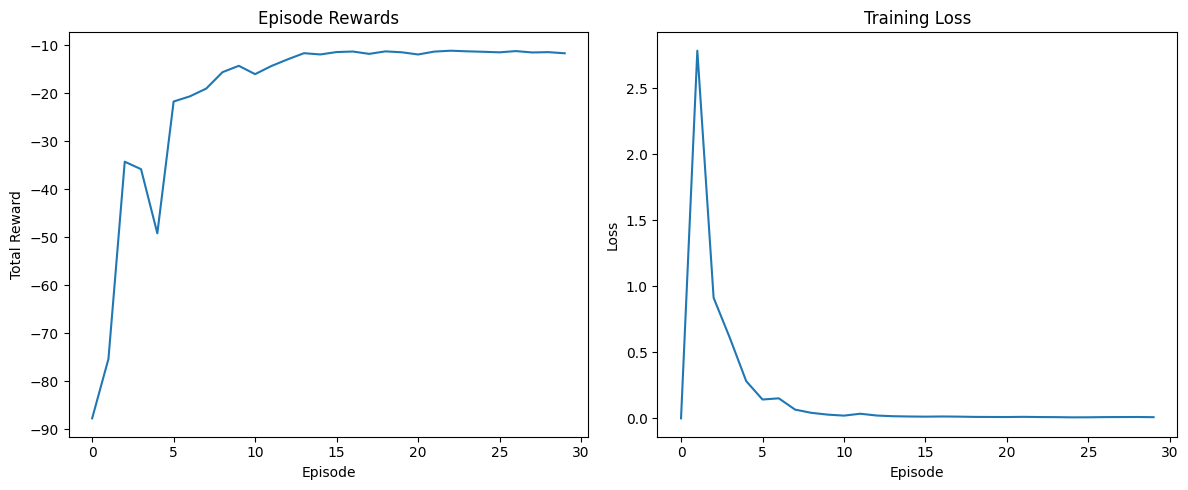

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train the agent (assuming cont_env is already defined)
agent, scores = train_dqn(cont_env, episodes=30, device=device, visualize_interval=50)

# Save the trained model
agent.save("dqn_reactor_pytorch.pt")

# Final policy visualization
state_ranges = {
    'low': cont_env.observation_space.low,
    'high': cont_env.observation_space.high
}

# Create directory for Q-function visualizations
import os
os.makedirs("q_function_vis", exist_ok=True)

# Set of visualizations with different fixed values for the 3rd dimension
for third_dim_value in np.linspace(state_ranges['low'][2], state_ranges['high'][2], 5):
    fixed_states = {2: third_dim_value}
    
    # Basic policy visualization
    fig = agent.plot_policy_grid(
        state_ranges, 
        fixed_states=fixed_states,
        resolution=30,
        selected_dims=[0, 1],
        plot_q_values=False
    )
    plt.suptitle(f'Final Policy (3rd dim = {third_dim_value:.3f})')
    plt.savefig(f"policy_3rd_dim_{third_dim_value:.3f}.png")
    plt.close(fig)
    
    # Detailed Q-function visualization
    fig = agent.plot_policy_grid(
        state_ranges, 
        fixed_states=fixed_states,
        resolution=30,
        selected_dims=[0, 1],
        plot_q_values=True
    )
    plt.suptitle(f'Q-Function Visualization (3rd dim = {third_dim_value:.3f})')
    plt.savefig(f"q_function_vis/q_func_3rd_dim_{third_dim_value:.3f}.png")
    plt.close(fig)

# Create 3D visualization of the value function for a slice
from mpl_toolkits.mplot3d import Axes3D

# For 3D plot, use a fixed value for the 3rd dimension
middle_value = (state_ranges['low'][2] + state_ranges['high'][2]) / 2
fixed_states = {2: middle_value}

# Create grid
resolution = 30
x = np.linspace(state_ranges['low'][0], state_ranges['high'][0], resolution)
y = np.linspace(state_ranges['low'][1], state_ranges['high'][1], resolution)
X, Y = np.meshgrid(x, y)
Z = np.zeros((resolution, resolution))

# Compute value function for each grid point
for i in range(resolution):
    for j in range(resolution):
        state = np.zeros(agent.state_size)
        state[0] = x[i]
        state[1] = y[j]
        state[2] = middle_value
        _, value = agent.get_best_action_and_value(state)
        Z[j, i] = value

# Create 3D surface plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Add colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Value')

# Set labels
ax.set_xlabel(f'State dimension 0 (Ca)')
ax.set_ylabel(f'State dimension 1 (T)')
ax.set_zlabel('Value')
ax.set_title(f'3D Value Function Surface (3rd dim = {middle_value:.3f})')

# Save and close
plt.savefig("q_function_vis/value_function_3d.png")
plt.close(fig)

print("Training and visualization complete!")

In [ ]:
def visualize_policy_rollout(env, agent, num_episodes=3):
    """
    Run the trained policy and visualize the rollouts
    
    Parameters:
    - env: Environment to run the policy in
    - agent: Trained DQN agent
    - num_episodes: Number of episodes to run and visualize
    """
    os.makedirs("rollout_plots", exist_ok=True)
    
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()
        done = False
        
        # Track episode data
        states = [state.copy()]
        actions = []
        rewards = []
        total_reward = 0
        
        # Run episode
        step = 0
        while not done and step < env.N:
            # Select action using policy
            action = agent.act(state, training=False)
            
            # Take action
            next_state, reward, done,_, _ = env.step(action)
            
            # Store data
            actions.append(action[0])
            rewards.append(reward)
            total_reward += reward
            
            # Move to next state
            state = next_state
            states.append(state.copy())
            step += 1
        
        # Convert to numpy arrays for easier indexing
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        
        # Create figure for plotting
        fig = plt.figure(figsize=(15, 12))
        gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
        
        # Plot state trajectories
        ax1 = plt.subplot(gs[0, 0])
        ax1.plot(states[:, 0], label='State 0 (Ca)')
        ax1.axhline(y=0.86, color='r', linestyle='--', label='Goal (Ca=0.86)')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Ca')
        ax1.set_title(f'Episode {episode} - Ca Trajectory')
        ax1.legend()
        ax1.grid(True)
        
        ax2 = plt.subplot(gs[0, 1])
        ax2.plot(states[:, 1], label='State 1 (T)')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('T')
        ax2.set_title(f'Episode {episode} - Temperature Trajectory')
        ax2.legend()
        ax2.grid(True)
        
        if states.shape[1] > 2:  # If there's a third state dimension
            ax3 = plt.subplot(gs[1, 0])
            ax3.plot(states[:, 2], label='State 2')
            ax3.set_xlabel('Step')
            ax3.set_ylabel('State 2')
            ax3.set_title(f'Episode {episode} - State 2 Trajectory')
            ax3.legend()
            ax3.grid(True)
        
        # Plot actions
        ax4 = plt.subplot(gs[1, 1])
        ax4.plot(actions, label='Action (Temperature)')
        ax4.set_xlabel('Step')
        ax4.set_ylabel('Temperature')
        ax4.set_title(f'Episode {episode} - Action Trajectory')
        ax4.legend()
        ax4.grid(True)
        
        # Plot rewards
        ax5 = plt.subplot(gs[2, 0])
        ax5.plot(rewards, label='Reward')
        ax5.set_xlabel('Step')
        ax5.set_ylabel('Reward')
        ax5.set_title(f'Episode {episode} - Reward Trajectory')
        ax5.legend()
        ax5.grid(True)
        
        # Plot cumulative reward
        ax6 = plt.subplot(gs[2, 1])
        cumulative_rewards = np.cumsum(rewards)
        ax6.plot(cumulative_rewards, label='Cumulative Reward')
        ax6.set_xlabel('Step')
        ax6.set_ylabel('Cumulative Reward')
        ax6.set_title(f'Episode {episode} - Cumulative Reward')
        ax6.legend()
        ax6.grid(True)
        
        plt.tight_layout()
        plt.suptitle(f'Policy Rollout - Episode {episode} (Total Reward: {total_reward:.2f})', fontsize=16)
        plt.subplots_adjust(top=0.92)
        
        # Save figure
        plt.savefig(f"rollout_plots/rollout_episode_{episode}.png")
        plt.close(fig)
        
        # Create state-action trajectory plot
        if states.shape[1] >= 2:
            fig = plt.figure(figsize=(10, 8))
            ax = plt.subplot(111)
            
            # Create colormap for actions
            action_min = agent.action_low
            action_max = agent.action_high
            norm = plt.Normalize(action_min, action_max)
            
            # Plot trajectory with color representing action
            points = ax.scatter(states[:-1, 0], states[:-1, 1], 
                             c=actions, cmap='viridis', 
                             norm=norm, s=50)
            
            # Add colorbar
            cbar = plt.colorbar(points)
            cbar.set_label('Action (Temperature)')
            
            # Connect points with lines to show trajectory
            ax.plot(states[:-1, 0], states[:-1, 1], 'k-', alpha=0.3)
            
            # Mark start and end points
            ax.scatter(states[0, 0], states[0, 1], color='green', s=100, label='Start')
            ax.scatter(states[-2, 0], states[-2, 1], color='red', s=100, label='End')
            
            # Mark goal state if available
            ax.axhline(y=0.86, color='r', linestyle='--', alpha=0.5)
            ax.axvline(x=0.86, color='r', linestyle='--', alpha=0.5)
            
            # Labels and title
            ax.set_xlabel('State dimension 0 (Ca)')
            ax.set_ylabel('State dimension 1 (T)')
            ax.set_title(f'State-Action Trajectory - Episode {episode}')
            ax.legend()
            ax.grid(True)
            
            # Save figure
            plt.tight_layout()
            plt.savefig(f"rollout_plots/state_action_trajectory_episode_{episode}.png")
            plt.close(fig)
            
    print(f"Generated rollout visualizations for {num_episodes} episodes")

In [25]:
visualize_policy_rollout(cont_env, agent, num_episodes=5)

AttributeError: 'tuple' object has no attribute 'copy'